In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hinge_loss, log_loss
from sklearn.svm import SVC, LinearSVC

In [2]:
hotel_booking_data = pd.read_csv('hotel_bookings.csv')
hotel_booking_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [3]:
#dealing with missing data
hotel_booking_data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### Visualizations

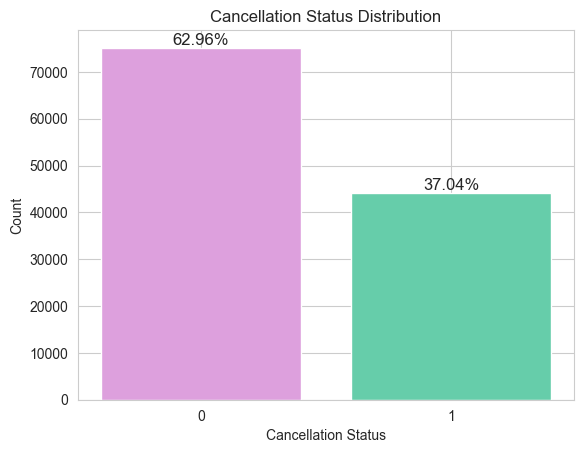

In [4]:
cancelled_counts = hotel_booking_data['is_canceled'].value_counts()
total_counts = len(hotel_booking_data)
colors = ['plum', 'mediumaquamarine']

plt.bar(cancelled_counts.index, cancelled_counts.values, color=colors)
plt.xticks(cancelled_counts.index, ['0', '1'])
plt.xlabel('Cancellation Status')
plt.ylabel('Count')
plt.title('Cancellation Status Distribution')

for i, count in enumerate(cancelled_counts):
    percentage = count / total_counts * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=12)
plt.show()

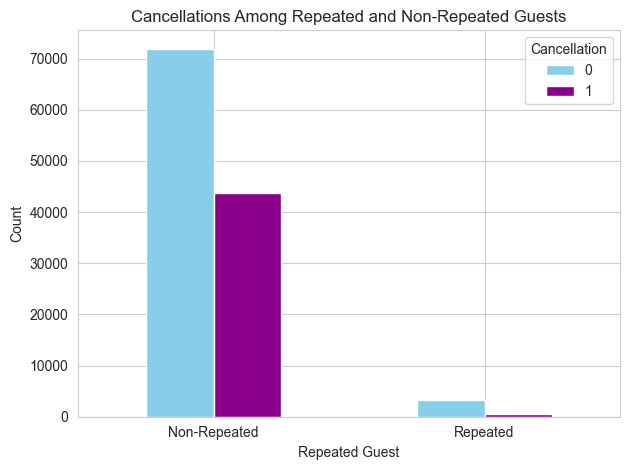

In [5]:
grouped_data = hotel_booking_data.groupby(['is_repeated_guest', 'is_canceled']).size().unstack()
grouped_data.plot(kind='bar', color=["skyblue", "darkmagenta"])

plt.xlabel('Repeated Guest')
plt.ylabel('Count')
plt.title('Cancellations Among Repeated and Non-Repeated Guests')
plt.xticks([0, 1], ['Non-Repeated', 'Repeated'], rotation=0)
plt.legend(title='Cancellation')

plt.tight_layout()
plt.show()

/Users/dogaturkseven/project/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dogaturkseven/project/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dogaturkseven/project/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Lead Time Distribution by Cancelation Status')

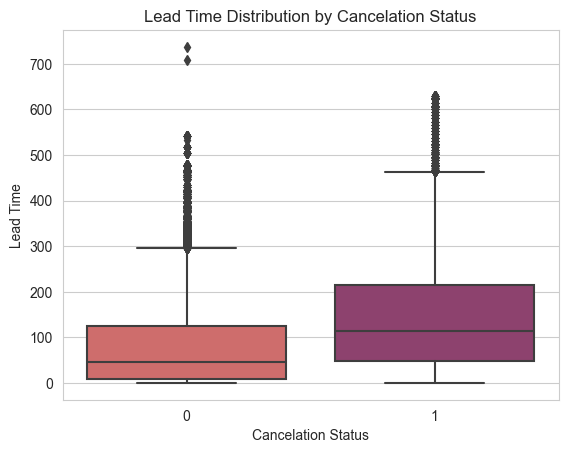

In [6]:
sns.boxplot(x='is_canceled',y='lead_time',data=hotel_booking_data, palette='flare')
plt.xlabel('Cancelation Status')
plt.ylabel('Lead Time')
plt.title('Lead Time Distribution by Cancelation Status')

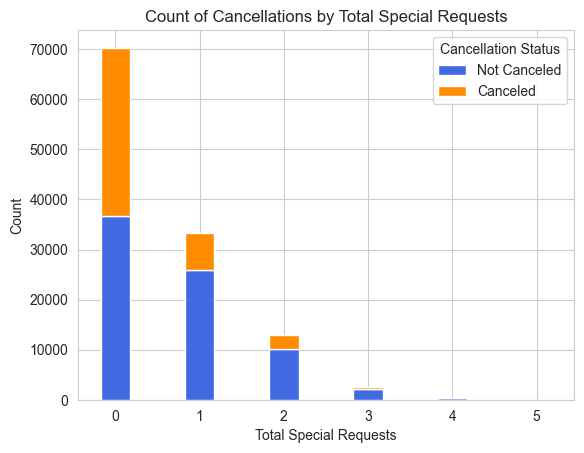

In [7]:
colors = ['royalblue', 'darkorange']

count_data = hotel_booking_data.groupby(['total_of_special_requests', 'is_canceled']).size().unstack()
bar_width = 0.35
index = range(len(count_data))

fig, ax = plt.subplots()

bars_0 = ax.bar(index, count_data[0], bar_width, color=colors[0], label='Not Canceled')
bars_1 = ax.bar(index, count_data[1], bar_width, color=colors[1], label='Canceled', bottom=count_data[0])

plt.xlabel('Total Special Requests')
plt.ylabel('Count')
plt.title('Count of Cancellations by Total Special Requests')
plt.xticks(index, count_data.index)
plt.legend(title='Cancellation Status', labels=['Not Canceled', 'Canceled'])
plt.show()

### Missing values and feature engineering

In [8]:
hotel_booking_data.children.value_counts()

children
0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: count, dtype: int64

In [9]:
#Agent and company has a lot of missing values, so they will be dropped.
hotel_booking_data =hotel_booking_data.drop(['company', 'agent'], axis =1)
#Children has only four missing values, we can replace missing data with zero because most of the values are zero. And there are also missing values for 'country' but compared to the total row count - 119390, it is realy small. We can use most frequent values.
hotel_booking_data['children'] =  hotel_booking_data['children'].fillna(0)
hotel_booking_data['country'] = hotel_booking_data['country'].fillna(hotel_booking_data['country'].mode()[0])

#Meal contains values "Undefined", which are equal to SC as explained in the data description.
hotel_booking_data["meal"].replace("Undefined", "SC", inplace=True)


hotel_booking_data['number_of_guests'] = hotel_booking_data['children'] + hotel_booking_data['babies'] + hotel_booking_data['adults']
no_guest = list(hotel_booking_data.loc[hotel_booking_data["number_of_guests"]==0].index)
#dropping the entries without any guests
hotel_booking_data.drop(hotel_booking_data.index[no_guest], inplace=True)
hotel_booking_data = hotel_booking_data.drop(['adults', 'children', 'babies'], axis =1)

In [10]:
hotel_booking_data['arrival_date_month'].replace({'January' : '1', 'February' : '2','March' : '3',
        'April' : '4', 'May' : '5', 'June' : '6', 'July' : '7', 'August' : '8','September' : '9', 
        'October' : '10','November' : '11','December' : '12'}, inplace=True)

hotel_booking_data['arrival_date_month'] = hotel_booking_data['arrival_date_month'].astype(int)

In [11]:
hotel_booking_data.groupby("is_canceled")["reservation_status"].value_counts()

is_canceled  reservation_status
0            Check-Out             75011
1            Canceled              42993
             No-Show                1206
Name: count, dtype: int64

In [12]:
hotel_booking_data = hotel_booking_data.drop(['reservation_status' , 'reservation_status_date' ,'arrival_date_week_number'], axis=1)

In [13]:
numerics = ['int64', 'float64']
numerical_features = hotel_booking_data.select_dtypes(include=numerics)

In [14]:
corr = numerical_features.corr()['is_canceled']
corr.abs().sort_values(ascending=False)[:]

is_canceled                       1.000000
lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
adr                               0.046492
number_of_guests                  0.044826
stays_in_week_nights              0.025542
arrival_date_year                 0.016622
arrival_date_month                0.011179
arrival_date_day_of_month         0.005948
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

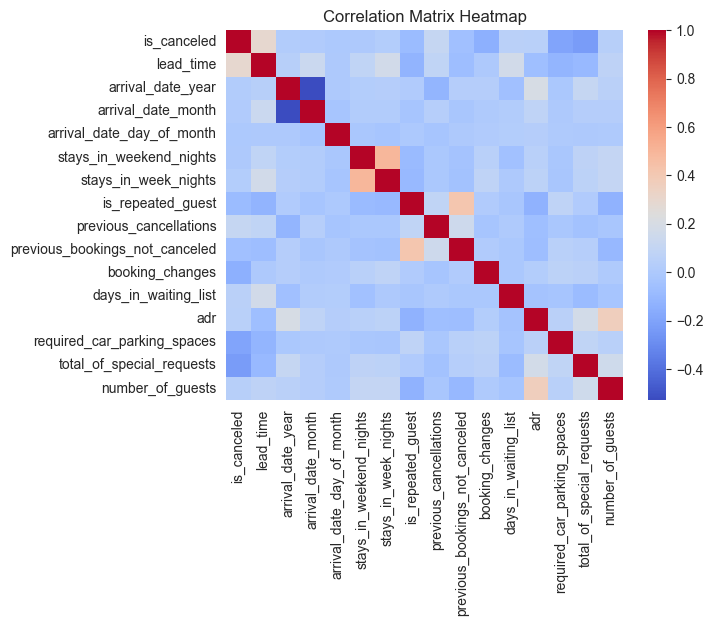

In [15]:
correlation_matrix = numerical_features.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.savefig('correlation_matrix.png')
plt.show()

In [16]:
categorical_features = ["hotel","meal", "country", "market_segment",
                "distribution_channel","reserved_room_type", "assigned_room_type", "deposit_type","customer_type"]

le = LabelEncoder()
for feature in categorical_features:
    hotel_booking_data[feature] = le.fit_transform(hotel_booking_data[feature])

In [17]:
X =  hotel_booking_data.drop(["is_canceled"], axis=1).to_numpy()
y = hotel_booking_data["is_canceled"].to_numpy()
y = np.where(y == 0, -1, y)

In [18]:
std_scaler = StandardScaler()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=1111)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1111)
std_scaler.fit(X_train)

StandardScaler()

In [19]:
X_train= std_scaler.transform(X_train)
X_val = std_scaler.transform(X_val)
X_test = std_scaler.transform(X_test)

### First method - Logistic Regression

In [20]:
model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train)

y_pred_train = model.predict_proba(X_train)
y_pred_tr = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_tr)

train_error = log_loss(y_train, y_pred_train)

y_pred_val = model.predict_proba(X_val)
y_pred_v = model.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_v)
val_error = log_loss(y_val, y_pred_val)

y_pred_test = model.predict_proba(X_test)
y_pred_ts = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_ts)
test_error = log_loss(y_test, y_pred_test)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", validation_accuracy)
print("Test Accuracy:",test_accuracy)

print("-------------")

print("Training Error:", train_error)
print("Validation Error:", val_error)
print("Test Error:", test_error)

Training Accuracy: 0.794787909291726
Validation Accuracy: 0.79854877946481
Test Accuracy: 0.7930962167603389
-------------
Training Error: 0.4255134767362517
Validation Error: 0.42099871545695083
Test Error: 0.4257950069094538


### Second method - SVM

In [21]:
#0.00001, 5, 20
svm_model = SVC()
svm_model.fit(X_train, y_train)

y_pred_train_svm = svm_model.predict(X_train)
train_accuracy_svm = accuracy_score(y_train, y_pred_train_svm)
train_error_svm = hinge_loss(y_train, y_pred_train_svm)

y_pred_val_svm = svm_model.predict(X_val)
validation_accuracy_svm = accuracy_score(y_val, y_pred_val_svm)
val_error_svm = hinge_loss(y_val, y_pred_val_svm)

y_pred_test_svm = svm_model.predict(X_test)
test_accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
test_error_svm = hinge_loss(y_test, y_pred_test_svm)



print("Training Accuracy:", train_accuracy_svm)
print("Validation Accuracy:", validation_accuracy_svm)
print("Test Accuracy:", test_accuracy_svm)

print("Training Error:", train_error_svm)
print("Validation Error:",val_error_svm)
print("Test Error:", test_error_svm)

Training Accuracy: 0.8516343707183401
Validation Accuracy: 0.8442664206022985
Test Accuracy: 0.8443083633923328
Training Error: 0.2967312585633196
Validation Error: 0.31146715879540304
Test Error: 0.31138327321533427


### Accuracy and Error plots

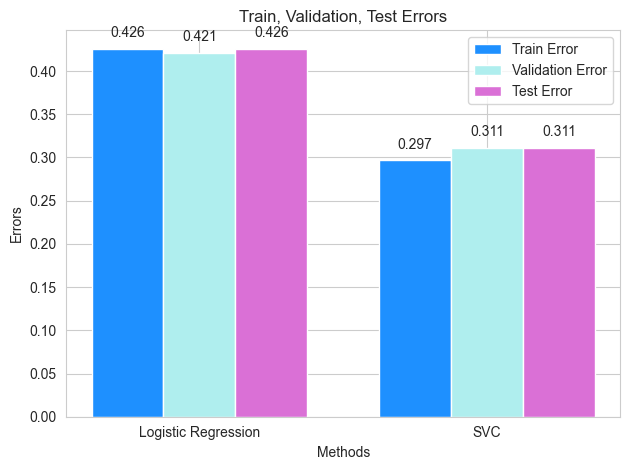

In [22]:
methods = ['Logistic Regression', 'SVC']
train_errors_list = [train_error, train_error_svm]  
validation_errors_list = [val_error, val_error_svm]  
test_errors_list = [test_error, test_error_svm] 

n = 2  
width = 0.25  
x = np.arange(n)  

fig, ax = plt.subplots()

train_bars = ax.bar(x - width, train_errors_list, width, label='Train Error', color='dodgerblue')
validation_bars = ax.bar(x, validation_errors_list, width, label='Validation Error', color='paleturquoise')
test_bars = ax.bar(x + width, test_errors_list, width, label='Test Error', color='orchid')

ax.set_xlabel('Methods')
ax.set_ylabel('Errors')
ax.set_title('Train, Validation, Test Errors')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
    
for bars, errors_list in zip([train_bars, validation_bars, test_bars], [train_errors_list, validation_errors_list, test_errors_list]):
    for bar, value in zip(bars, errors_list):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.savefig('errors.png')
plt.tight_layout()
plt.show()


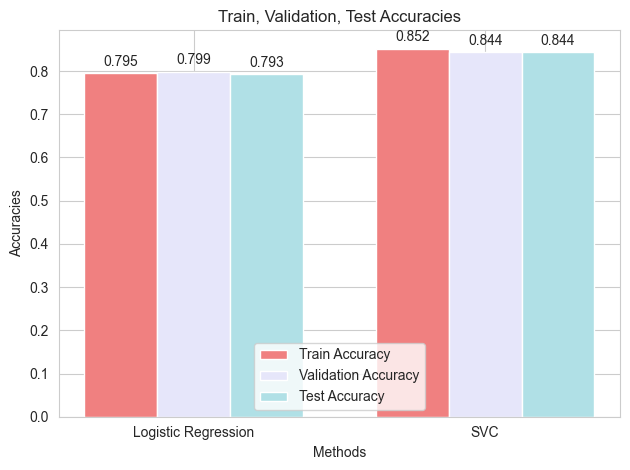

In [23]:
methods = ['Logistic Regression', 'SVC']
train_accuracies_list = [train_accuracy, train_accuracy_svm]  
validation_accuracies_list = [validation_accuracy, validation_accuracy_svm]  
test_accuracies_list = [test_accuracy, test_accuracy_svm] 

n = 2  
width = 0.25  
x = np.arange(n) 

fig, ax = plt.subplots()

train_bars = ax.bar(x - width, train_accuracies_list, width, label='Train Accuracy', color='lightcoral')
validation_bars = ax.bar(x, validation_accuracies_list, width, label='Validation Accuracy', color='lavender')
test_bars = ax.bar(x + width, test_accuracies_list, width, label='Test Accuracy', color='powderblue')

ax.set_xlabel('Methods')
ax.set_ylabel('Accuracies')
ax.set_title('Train, Validation, Test Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
    
for bars, errors_list in zip([train_bars, validation_bars, test_bars], [train_accuracies_list, validation_accuracies_list, test_accuracies_list]):
    for bar, value in zip(bars, errors_list):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.savefig('accuracies.png')
plt.tight_layout()
plt.show()


### Features

- hotel: Resort hotel or city otel
- is_canceled: Value indicating if the booking was canceled (1) or not (0)
- arrival_date_year: Year of arrival date
- arrival_date_month: Month of arrival date
- arrival_date_week_number: Week number of year for arrival date
- arrival_date_day_of_month: Day of arrival date
- stays_in_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- stays_in_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- adults: Number of adults
- children: Number of children
- babies: Number of babies
- meal: Type of meal booked 
- country: Country of origin
- market_segment: Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- distribution_channel: Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- is_repeated_guest: Value indicating if the booking name was from a repeated guest (1) or not (0)
- previous_bookings_not_canceled: Number of previous bookings not cancelled by the customer prior to the current booking
- reserved_room_type: Code of room type reserved
- assigned_room_type: Code for the type of room assigned to the booking
- deposit_type: Indication on if the customer made a deposit to guarantee the booking
- agent: ID of the travel agency that made the booking
- company: ID of the company/entity that made the booking or responsible for paying the booking
- days_in_waiting_list: Number of days the booking was in the waiting list before it was confirmed to the customer
- customer_type: Type of booking
- adr: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- reservation_status: Reservation last status
- reservation_status_date: Date at which the last status was set